## 감정분석

### 인스타그램에서 크롤링 해 온 데이터(영어)를 긍부정 검사, 긍부정 개수 확인 

#### 1. afinn(영어 긍부정 감정사전) 활용 점수화

In [35]:
import pandas as pd
from afinn import Afinn
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15228\354392695.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_wheat.main_text = df_wheat.main_text.str.replace('[^A-Za-z]',' ').str.strip()


긍정: 241, 중립: 200, 부정: 59  // 개수



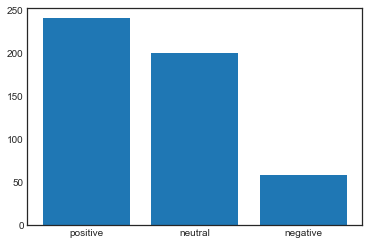

점수: 1234.0


In [36]:
df_wheat = pd.read_csv("../data/감성분석/crawling/instagram_Wheat.csv")
df_wheat.main_text = df_wheat.main_text.str.replace('[^A-Za-z]',' ').str.strip()

positive = 0
neutral = 0
negative = 0
total = 0

for i in df_wheat.main_text:
    score = Afinn().score(i)
    if score > 0:
        positive += 1
    elif score == 0:
        neutral += 1
    else:
        negative += 1
    total += score
print(f"긍정: {positive}, 중립: {neutral}, 부정: {negative}  // 개수\n")
plt.bar(np.arange(3), [positive, neutral, negative])
plt.xticks(np.arange(3), ['positive', 'neutral', 'negative'])
plt.show()
print("점수:",total)


#### 2. 수업내용 활용 이진분류

    - cvect, nb

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
import joblib

In [37]:
df_eng_train = pd.read_csv('../data/감성분석/kor_train_data/labeledTrainData.tsv', sep='\t', quoting=3)

df_eng_train.review = df_eng_train.review.str.replace('<br />','')
df_eng_train.review = df_eng_train.review.str.replace('[^A-Za-z]',' ').str.strip()

# Train/Test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(
    df_eng_train.review, df_eng_train.sentiment, stratify=df_eng_train.sentiment, random_state=2022
)

# CountVectorizer로 변환
cvect = CountVectorizer(ngram_range=(1,2), stop_words='english')
cvect.fit(X_train)
X_train_cv = cvect.transform(X_train)
X_test_cv = cvect.transform(X_test)

# 분류기: Naive Bayes
nb.fit(X_train_cv, y_train)
print(nb.score(X_test_cv, y_test))


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3108\664746291.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_eng_train.review = df_eng_train.review.str.replace('[^A-Za-z]',' ').str.strip()


0.86768


긍정: 253, 부정: 247  // 개수


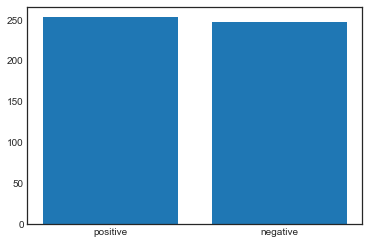

In [39]:
positive = 0
negative = 0

for i in df_wheat.main_text:
    review_cv = cvect.transform([i])
    score = nb.predict(review_cv)
    if score == 1:
        positive += 1
    else:
        negative += 1

print(f"긍정: {positive}, 부정: {negative}  // 개수")
plt.bar(np.arange(2), [positive, negative])
plt.xticks(np.arange(2), ['positive', 'negative'])
plt.show()

    - cvect, lr

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
nb = MultinomialNB()
import joblib
from sklearn.model_selection import GridSearchCV


In [16]:
cvect = CountVectorizer(ngram_range=(1,2), stop_words='english')
lr = LogisticRegression(random_state=2022)
pipeline = Pipeline([('CVECT', cvect), ('LR', lr)])
%time pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

c:\ProgramData\Miniconda3\envs\kdig\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 2min 31s
Wall time: 50 s


0.88016

In [21]:
# 최적 파라미터 찾기
params = {
    'CVECT__ngram_range': [(1,1),(1,2)],
    'CVECT__max_df': [0.90, 0.99],
    'LR__C': [1,5]
}

grid_pipe = GridSearchCV(pipeline, params, scoring='accuracy', cv=5, n_jobs=-1)
grid_pipe.fit(X_train, y_train)

c:\ProgramData\Miniconda3\envs\kdig\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Miniconda3\envs\kdig\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Miniconda3\envs\kdig\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\Miniconda3\envs\kdig\lib\site-packages\sklearn\linear_model\_logistic.py", line 1589, in fit
    fold_coe

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CVECT',
                                        CountVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('LR',
                                        LogisticRegression(random_state=2022))]),
             n_jobs=-1,
             param_grid={'CVECT__max_df': [0.9, 0.99],
                         'CVECT__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'LR__C': [1, 5]},
             scoring='accuracy')

In [22]:
grid_pipe.score(X_test, y_test)

0.87824

In [19]:
# 모델 저장
# joblib.dump(grid_pipe.best_estimator_,'../data/감성분석/model/영어.pkl')

['../data/인스타그램크롤링/영어.pkl']

긍정: 393, 부정: 107  // 개수


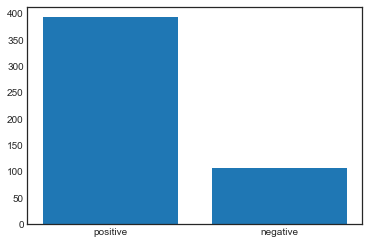

In [46]:
pipeline = joblib.load('../data/감성분석/model/영어.pkl')

positive = 0
negative = 0

for i in df_wheat.main_text:
    score = pipeline.predict([i])
    if score == 1:
        positive += 1
    else:
        negative += 1

print(f"긍정: {positive}, 부정: {negative}  // 개수")
plt.bar(np.arange(2), [positive, negative])
plt.xticks(np.arange(2), ['positive', 'negative'])
plt.show()

### 인스타그램에서 크롤링 해 온 데이터(한국어)를 긍부정 검사, 긍부정 개수 확인 

#### 1. 영화리뷰 배운내용 활용 이진분류

In [27]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from konlpy.tag import Okt
okt = Okt()
import urllib.request
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib


In [28]:
# 영화리뷰 데이터 학습 및 테스트

train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

# Null 데이터 제거
train_data.dropna(how='any', inplace=True)
test_data.dropna(how='any', inplace=True)
# 중복데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

# 정규표현식
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
train_data['document'].replace("",np.nan, inplace=True)
train_data.dropna(how='any', inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
test_data['document'].replace("",np.nan, inplace=True)
test_data.dropna(how='any', inplace=True)
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']



X_train = []
for sentence in tqdm(train_data.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_str = ' '.join([word for word in morphs if word not in stopwords])
    X_train.append(tmp_str)

X_test = []
for sentence in tqdm(test_data.document):
    morphs = okt.morphs(sentence, stem=True)
    tmp_str = ' '.join([word for word in morphs if word not in stopwords])
    X_test.append(tmp_str)

y_train = train_data.label.values
y_test = test_data.label.values

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15228\2387385312.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15228\2387385312.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")


  0%|          | 0/146182 [00:00<?, ?it/s]

  0%|          | 0/49157 [00:00<?, ?it/s]

In [29]:
#모델 학습, 평가

cvect = CountVectorizer()
lr = LogisticRegression(random_state=2022)
pipeline = Pipeline([('CVECT', cvect), ('LR', lr)])
%time pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

c:\ProgramData\Miniconda3\envs\kdig\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 14.6 s
Wall time: 5.34 s


0.82486726203796

In [30]:
# 최적 파라미터 찾기
params = {
    'CVECT__ngram_range': [(1,1),(1,2)],
    'CVECT__max_df': [0.90, 0.99],
    'LR__C': [1,5]
}

grid_pipe = GridSearchCV(pipeline, params, scoring='accuracy', cv=3, n_jobs=-1)
grid_pipe.fit(X_train, y_train)

c:\ProgramData\Miniconda3\envs\kdig\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('CVECT', CountVectorizer()),
                                       ('LR',
                                        LogisticRegression(random_state=2022))]),
             n_jobs=-1,
             param_grid={'CVECT__max_df': [0.9, 0.99],
                         'CVECT__ngram_range': [(1, 1), (1, 2)],
                         'LR__C': [1, 5]},
             scoring='accuracy')

In [31]:
# 모델 저장
# joblib.dump(grid_pipe.best_estimator_,'../data/감성분석/model/한글(영화).pkl')

# 모델 로드
# best_pipe = joblib.load('.pkl')

['../data/감성분석/model/한글(영화).pkl']

In [47]:
# 사용 x
def sentiment_predict(new_sentence, pipeline):
    '''
    입력 된 문장을 전처리 후 토큰화, 파이프 라인으로 예측한 값을 리턴
    '''
    new_sentence = str(new_sentence)
    new_sentence = re.sub('[^가-힣]', ' ', new_sentence)
    morphs = okt.morphs(new_sentence, stem=True)
    new_sentence = ' '.join([word for word in okt.morphs(new_sentence, stem=True) if word not in stopwords])
    return pipeline.predict([new_sentence])

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15228\3880671722.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_corn.main_text = df_corn.main_text.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ').str.strip()


긍정: 87, 부정: 112  // 개수


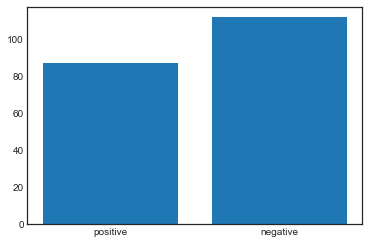

In [33]:
pipeline = joblib.load('../data/감성분석/model/한글(영화).pkl')
df_corn = pd.read_csv("../data/감성분석/crawling/instagram_옥수수.csv", sep=",")

df_corn.main_text = df_corn.main_text.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ').str.strip()
# df_corn.main_text.replace('', np.nan, inplace=True)
df_corn.main_text = df_corn.main_text.dropna()

positive = 0
negative = 0

for i in df_corn.main_text:
    score = pipeline.predict([i])
    score = score.astype(int)

    if score == 1:
        positive += 1
    else:
        negative += 1

print(f"긍정: {positive}, 부정: {negative}  // 개수")
plt.bar(np.arange(2), [positive, negative])
plt.xticks(np.arange(2), ['positive', 'negative'])
plt.show()


#### 2. ai_hub 데이터 이용

    - cvect, lr

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import joblib

In [23]:
df = pd.read_excel("../data/감성분석/kor_train_data/한국어_단발성_대화_데이터셋.xlsx")
df1 = df[['Sentence','Emotion']]
df2 = df1[(df1.Emotion == '행복') | (df1.Emotion == '슬픔')]
df3 = df2.replace("슬픔",0).replace("행복",1)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    df3.Sentence, df3.Emotion, stratify=df3.Emotion, random_state=2022
)

#모델 학습, 평가
cvect = CountVectorizer()
lr = LogisticRegression(random_state=2022)
pipeline = Pipeline([('CVECT', cvect), ('LR', lr)])
%time pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)


CPU times: total: 1.66 s
Wall time: 686 ms


0.7749469214437368

In [139]:
# 최적 파라미터 찾기
params = {
    'CVECT__ngram_range': [(1,1),(1,2)],
    'CVECT__max_df': [0.90, 0.99],
    'LR__C': [1,5]
}

grid_pipe = GridSearchCV(pipeline, params, scoring='accuracy', cv=5, n_jobs=-1)
grid_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CVECT', CountVectorizer()),
                                       ('LR',
                                        LogisticRegression(random_state=2022))]),
             n_jobs=-1,
             param_grid={'CVECT__max_df': [0.9, 0.99],
                         'CVECT__ngram_range': [(1, 1), (1, 2)],
                         'LR__C': [1, 5]},
             scoring='accuracy')

In [140]:
# 모델 저장
# joblib.dump(grid_pipe.best_estimator_,'../data/감성분석/model/한글.pkl')

['../data/감성분석/model/한글.pkl']

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15228\3362083930.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_corn.main_text = df_corn.main_text.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ').str.strip()


긍정: 155, 부정: 44  // 개수


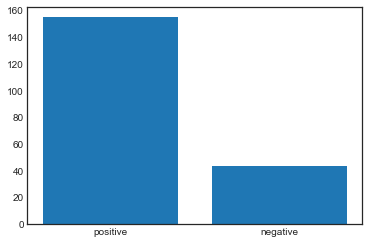

In [5]:
pipeline = joblib.load('../data/감성분석/model/한글.pkl')
df_corn = pd.read_csv("../data/감성분석/crawling/instagram_옥수수.csv", sep=",")

df_corn.main_text = df_corn.main_text.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ').str.strip()
# df_corn.main_text.replace('', np.nan, inplace=True)
df_corn.main_text = df_corn.main_text.dropna()


positive = 0
negative = 0

for i in df_corn.main_text:
    score = pipeline.predict([i])
    score = score.astype(int)

    if score == 1:
        positive += 1
    else:
        negative += 1

print(f"긍정: {positive}, 부정: {negative}  // 개수")
plt.bar(np.arange(2), [positive, negative])
plt.xticks(np.arange(2), ['positive', 'negative'])
plt.show()

    - cvect, nb

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import joblib

In [42]:
df = pd.read_excel("../data/감성분석/kor_train_data/한국어_단발성_대화_데이터셋.xlsx")
df1 = df[['Sentence','Emotion']]
df2 = df1[(df1.Emotion == '행복') | (df1.Emotion == '슬픔')]
df3 = df2.replace("슬픔",0).replace("행복",1)

X_train, X_test, y_train, y_test = train_test_split(
    df3.Sentence, df3.Emotion, stratify=df3.Emotion, random_state=2022
)

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

# CountVectorizer로 변환
cvect = CountVectorizer(ngram_range=(1,2), stop_words=stopwords)
cvect.fit(X_train)
X_train_cv = cvect.transform(X_train)
X_test_cv = cvect.transform(X_test)
# 분류기: Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)
print(nb.score(X_test_cv, y_test))



0.7699929228591649


In [44]:
# joblib.dump(cvect,"../data/감성분석/model/한글_cvect.pkl")
# joblib.dump(nb,"../data/감성분석/model/한글_nb.pkl")

['../data/감성분석/model/한글_nb.pkl']

긍정: 158, 부정: 41  // 개수


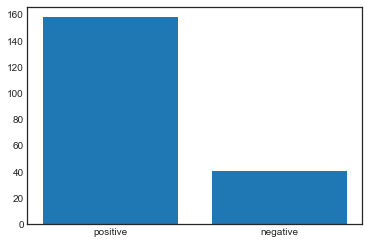

In [25]:
positive = 0
negative = 0

for i in df_corn.main_text:
    review_cv = cvect.transform([i])
    score = nb.predict(review_cv)
    if score == 1:
        positive += 1
    else:
        negative += 1

print(f"긍정: {positive}, 부정: {negative}  // 개수")
plt.bar(np.arange(2), [positive, negative])
plt.xticks(np.arange(2), ['positive', 'negative'])
plt.show()